In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
import os as os
import multiprocessing
from joblib import Parallel, delayed
from time import time as ti
from skimage.restoration import denoise_wavelet
import pickle
#import CoreFunctions as cf
import sys
import random
import psutil
import gc

In [2]:
DataFolder = '/sciclone/scr10/dchendrickson01/Recordings2/'
DataFolder = '/scratch/Recordings2/'

DateString = 'Good'
LastGoodModel = 6

TIME_STEPS = 1200
Skips = 125
RollSize = 50

LastSuccesfull = LastGoodModel

tic = ti()
start = tic

MemoryProtection = True

LR_Starting = 3e-2
LR_PeriodGrow = 6
LR_Decay = .75
LR_Expand = 2.5

In [3]:
%matplotlib inline

In [4]:
RunTwice = True

In [5]:
FilesPerRun = 10
ConcurrentFiles = 5

In [6]:
def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs
    del Diffs
    
    Sqs = Sqs.tolist() 
    Sqs.extend(np.zeros(RollSize))
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    StdDevs = np.sqrt(VarVect)
    return np.asarray(StdDevs[:-RollSize].T)

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def split_list_by_zeros(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if not is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips):
    output = []
    for i in range(int((len(values) - time_steps + skips)/skips)):
        output.append(values[i*skips : (i*skips + time_steps)])
    return np.stack(output)

In [7]:
def runFile(file, verbose = False, small = False, index=0, start=ti()):
    noise = verbose
    if file[-4:] == '.csv':    
        dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')
        if noise:
            print("File Read", ti()-start)
        dataset = dataset.rename(columns={0:"Day"})
        dataset = dataset.rename(columns={1:"Second"})
        dataset = dataset.rename(columns={2:"FracSec"})
        dataset = dataset.rename(columns={3:"p"})
        dataset = dataset.rename(columns={4:"h"})
        dataset = dataset.rename(columns={5:"v"})
        dataset = dataset.rename(columns={6:"Sensor"})

        #dataset['Second'].replace('',0)
        #dataset['FracSec'].replace('',0)
        #dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)
        
        #dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
        #dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))

        #dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
        #dataset["timestamps"] = dataset["timestamp"]

        dataset["p"] = dataset.p - np.average(dataset.p)
        dataset["h"] = dataset.h - np.average(dataset.h)
        dataset["v"] = dataset.v - np.average(dataset.v)
        #dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)

        #dataset.index = dataset.timestamp

        dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        #dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')

        if noise:
            print("Data Cleaned", ti()-start, len(dataset.p))

        RawData = dataset.v
        SmoothData = dataset.SmoothV
        RollSize = 25

        Diffs = RawData - SmoothData

        Sqs = Diffs * Diffs

        Sqs = Sqs.tolist() 

        Sqs.extend(np.zeros(RollSize))

        mSqs = np.matrix(Sqs)

        for i in range(RollSize):
            Sqs.insert(0, Sqs.pop())
            mSqs = np.concatenate((np.matrix(Sqs),mSqs))

        sVect = mSqs.sum(axis=0)
        eVect = (mSqs!=0).sum(axis=0)

        VarVect = sVect / eVect

        StdDevs = np.sqrt(VarVect)

        StdDevsZ = np.asarray(StdDevs)

        StdDevsZ=np.append(StdDevsZ,[0])

        StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])

        if noise:
            print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))

        #StdDevsZ = np.nan_to_num(StdDevsZ)

        #StdDevsZ[StdDevsZ == np.inf] = 0
        #StdDevsZ[StdDevsZ == -np.inf] = 0

        if noise:
            print("cleaned", ti()-start, np.shape(StdDevsZ))

        SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')

        if noise:
            print("denoise 1", ti()-start, np.shape(StdDevsZ))

        #SmoothDevZa = cf.Smoothing(StdDevsZ, 3, wvt='sym2', dets_to_remove=2, levels=3)
        #SmoothDevZ = np.ravel(SmoothDevZ[0,:])

        #SmoothDevZ = SmoothDevZ.tolist()

        if noise:
            print("denoise 2", ti()-start, np.shape(SmoothDevZ))

        #ataset["SmoothDevZ"] = SmoothDevZ

        SmoothDevZ[np.isnan(SmoothDevZ)]=0
        
        Max = np.max(SmoothDevZ)

        
        
        if noise:
            print("Max", ti()-start, np.shape(Max), Max)

        buckets = int(Max / 0.005) + 1
        bins = np.linspace(0,buckets*0.005,buckets+1)
        counts, bins = np.histogram(SmoothDevZ,bins=bins)

        CummCount = 0
        HalfWay = 0
        for i in range(len(counts)):
            CummCount += counts[i]
            if CummCount / len(SmoothDevZ) >= 0.5:
                if HalfWay == 0:
                    HalfWay = i

        SquelchLevel = bins[HalfWay] 
        if noise:
            print("SmoothDevz size", np.shape(SmoothDevZ))

        dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 4000, SquelchLevel, verbose=noise)

        if noise:
            print("Squelch Made", ti()-start)
        #dataset["velocity"] = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)
        #if noise:
        #    print("Velocity Calculated.  File done: ",file)

        #df_pr = split_list_by_ones(dataset.p, dataset.IsMoving)
        #df_hr = split_list_by_ones(dataset.h, dataset.IsMoving)
        #df_vr = split_list_by_ones(dataset.v, dataset.IsMoving)
        #df_rrr = split_list_by_ones(dataset.r, dataset.IsMoving)
        df_ps = split_list_by_zeros(dataset.SmoothP, dataset.IsMoving)
        df_hs = split_list_by_zeros(dataset.SmoothH, dataset.IsMoving)
        df_vs = split_list_by_zeros(dataset.SmoothV, dataset.IsMoving)
        #df_rs = split_list_by_zeros(dataset.SmoothR, dataset.IsMoving)

        del dataset
        
        MatsSmooth = []
        for i in range(len(df_ps)):
            MatsSmooth.append(np.vstack((df_ps[i],df_hs[i],df_vs[i]))) #,df_rs[i])))
        
        if verbose:
            print("Split by ones", ti()-start)


        '''df_p=[0]
        df_h=[0]
        df_v=[0]
        df_r=[0]
        df_rp=[0]
        df_rh=[0]
        df_rv=[0]
        df_rr=[0]
        for i in range(len(df_ps)):
            df_p += df_ps[i]
            df_h += df_hs[i]
            df_v += df_vs[i]
            df_r += df_rs[i]
            df_rp += df_pr[i]
            df_rh += df_hr[i]
            df_rv += df_vr[i]
            df_rr += df_rrr[i]
        '''
        if verbose:
            print('format changed', ti()-start, len(MatsSmooth))

        return MatsSmooth
    else:
        return ['fail','fail']
        
        #if verbose:
        #    print('Data normalized', ti()-start)

        #return df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr


In [8]:
def runWrapper(file_path, verbose=True, small=False, index=0, start=ti()):
    try:
        rtrn = runFile(file_path, verbose, small, index, start)
        return rtrn
    except Exception as e:
        with open('BadInputs.text', 'a') as bad_file:
            bad_file.write(file_path + '\n')
        return np.zeros((10, 10, 3))

In [9]:
with open('CurrentFileListGood.text','r') as file:
    files = file.readlines()
files=[item.strip() for item in files]

looked at files in groups 28-29-30, there was something wierd

### files[28:32]

In [10]:
for i in range(FilesPerRun):
    print(files[(i+1+LastSuccesfull*FilesPerRun)])

230512 recording1.csv
230513 recording1.csv
230514 recording1.csv
230515 recording1.csv
230515 recording1a.csv
230515 recording2.csv
230516 recording2.csv
230516 recording4.csv
230517 recording2.csv
230517 recording4.csv


In [11]:
%%time
AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runWrapper)(files[(i+1+LastSuccesfull*FilesPerRun)], False, False, 0, ti()) for i in range(FilesPerRun))


CPU times: user 480 ms, sys: 1.63 s, total: 2.11 s
Wall time: 6min 50s


In [12]:
Mats = []
for fileResponse in AllDatas:
    for Mat in fileResponse:
        Mats.append(Mat)

In [13]:
len(AllDatas[1])

825

In [14]:
lengths = []
rejects = []
Keeps = []

In [15]:
for Mat in Mats:
    spm = np.shape(Mat)
    if len(spm) > 1:
        lenM = spm[1]
    else:
        lenM = 1
    if (lenM > 1250):
        lengths.append(lenM)
        Keeps.append(Mat)
    else:
        rejects.append(lenM)

In [16]:
import CoreFunctions as cf

In [17]:
if MemoryProtection:
    print('RAM memory % used:', psutil.virtual_memory()[2])
    del Mats, AllDatas


RAM memory % used: 4.6


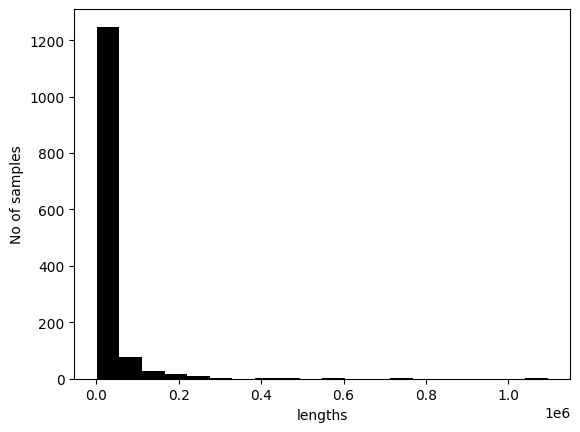

In [18]:
plt.hist(lengths, bins=20)
plt.xlabel("lengths")
plt.ylabel("No of samples")
plt.show()


In [19]:
Prints = []


In [20]:
def PrintWrap(Mat):
    localPrints = []
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 32, spacer = 2, title = ''))
        localPrints.append(temp.astype(np.float32)/255.0)
    return localPrints

In [21]:
%%time
AllPrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Keeps)

CPU times: user 5.03 s, sys: 22.7 s, total: 27.7 s
Wall time: 51.3 s


In [22]:
if MemoryProtection:
    print('RAM memory % used:', psutil.virtual_memory()[2])
    del Keeps

RAM memory % used: 13.3


In [23]:
for group in AllPrints:
    for fprint in group:
        Prints.append(fprint[:, ::2, :])

for Mat in Keeps:
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 60, spacer = 1, title = ''))
        Prints.append(temp.astype(np.float32)/255.0)

In [24]:
if MemoryProtection:
    print('RAM memory % used:', psutil.virtual_memory()[2])
    del AllPrints


RAM memory % used: 13.3


np.shape(Prints)

In [25]:
len(Prints)
random.shuffle(Prints)

In [26]:
for i in range(7):
    print(np.shape(Prints[i*13]))

(32, 600, 3)
(32, 600, 3)
(32, 600, 3)
(32, 600, 3)
(32, 600, 3)
(32, 600, 3)
(32, 600, 3)


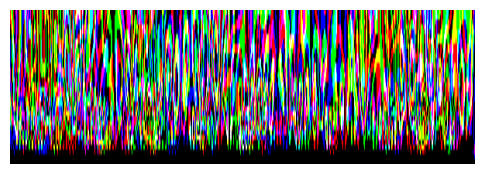

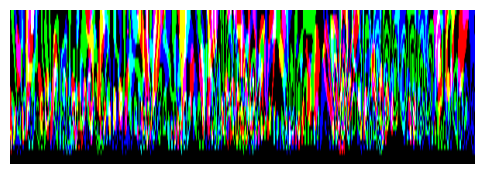

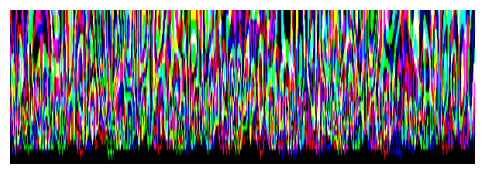

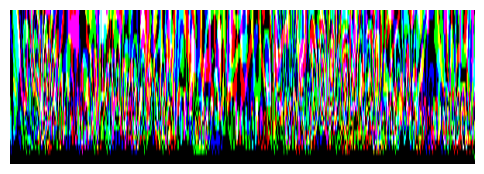

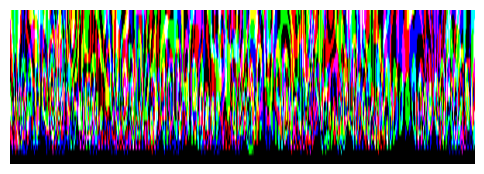

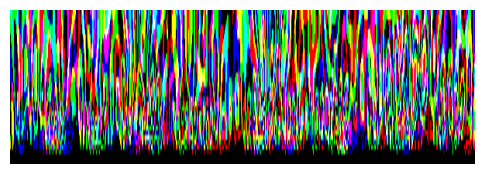

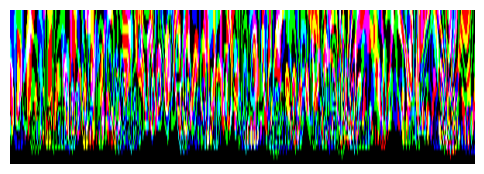

In [27]:
for i in range(7):
    fig = plt.figure(figsize=(6,2), dpi=100)
    plt.axis("off")
    plt.imshow(Prints[i*13], origin='lower',aspect='auto')
    plt.show()

# Start Machine Learning
## Using Autoencoder with Kears and Tensorflow
cite: https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

In [28]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
import numpy as np

2024-12-02 14:05:47.594213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 14:05:47.606763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 14:05:47.610244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 14:05:47.621597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(64, 128), latentDim=32):
        inputShape = (height, width, depth)
        chanDim = -1
        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (5, 5), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        print("Volume Size:", volumeSize)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        flattenedVolumeSize = int(np.prod(volumeSize[1:]))
        print("Flattened Volume Size:", flattenedVolumeSize)
        x = Dense(flattenedVolumeSize)(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            #x = Lambda(lambda y: y[:, :width, :])(x) #Select last N from output  
        
        #x = Cropping2D(cropping=((0, 0), (0, 8)))(x)
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

        return (encoder, decoder, autoencoder)


In [30]:
# set the matplotlib backend so figures can be saved in the background
#import matplotlib
#matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
# construct the argument parse and parse the arguments

In [31]:
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

In [32]:
from tensorflow.keras.callbacks import Callback

In [33]:
import keras
import re

In [34]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 128
TestSplit = 10 # 1/this many

# load the MNIST dataset

random.shuffle(Prints)

TestLength = int(len(Prints)/TestSplit)

In [35]:
np.shape(Prints)

(26704, 32, 600, 3)

In [36]:
print(type(Prints))
print(Prints[0].dtype)
print(np.shape(Prints))
print('RAM memory % used:', psutil.virtual_memory()[2])

<class 'list'>
float32
(26704, 32, 600, 3)
RAM memory % used: 13.4



# Assuming 'Prints' is your list

# Convert the list to a NumPy array with a consistent data type
try:
    prints_array = np.array(Prints, dtype=np.float32)
except Exception as e:
    print(f"Error converting to NumPy array: {e}")

# Check the shape and type of the NumPy array
print(f"Shape of prints_array: {prints_array.shape}")
print(f"Data type of prints_array: {prints_array.dtype}")

# Convert the NumPy array to a TensorFlow tensor
try:
    tensor_prints = tf.convert_to_tensor(prints_array)
    print(tensor_prints)
except Exception as e:
    print(f"Error converting to TensorFlow tensor: {e}")


In [37]:
for i, image in enumerate(Prints):
    if not isinstance(image, np.ndarray):
        Prints[i] = np.array(image, dtype=np.float32)
    elif image.dtype != np.float32:
        Prints[i] = image.astype(np.float32)

# Stack the images into a single NumPy array
prints_array = np.stack(Prints, axis=0)

if MemoryProtection:
    del Prints
    print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 18.0


In [38]:
if psutil.virtual_memory()[2] > 49:
    temp = (float(psutil.virtual_memory()[2]) - 50.0) / 50.0
    temp2 = int(np.shape(prints_array)[0]*temp)
    prints_array = prints_array[:temp2]

In [39]:
np.shape(prints_array)

(26704, 32, 600, 3)

In [40]:
# Convert the NumPy array to a TensorFlow tensor
tensor_prints = tf.convert_to_tensor(prints_array)

2024-12-02 14:06:11.126103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6


In [41]:
ImageShape = np.shape(tensor_prints)

In [42]:
if MemoryProtection:
    del prints_array
    print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 19.1


NP = []
for prt in Prints:
    temp = tf.convert_to_tensor(prt)
    NP.append(temp)
NP = tf.onvert_to_tensor(NP)

trainX = np.asarray(Prints[:TestLength]).astype('float32')

testX = Prints[TestLength:]

In [43]:
trX = tensor_prints[:TestLength]  #tf.convert_to_tensor(trainX, dtype=tf.float32)

In [44]:
teX = tensor_prints[TestLength:]  #tf.convert_to_tensor(testX, dtype=tf.float32)

In [45]:
if MemoryProtection:
    del tensor_prints

In [46]:
if LastGoodModel == 999:
    (encoder, decoder, autoencoder) = ConvAutoencoder.build(ImageShape[2], ImageShape[1], ImageShape[3],(128,128),16) 
    # (256,256),16) 12,986,899
    # (512,256),32)
    # (256,128),32)
    # (128,64),16)
else:

    directory = '/scratch/models/'
    '''
    # Regular expression to match the filenames
    pattern = re.compile(r'3DFP_(\d{4})_(\d{3})_good\.keras')
    
    # Initialize variables to track the highest numbers
    max_main_number = -1
    max_sub_number = -1
    target_file = None
    
    # Iterate over the files in the directory
    
    file_list = os.listdir(directory)
    for filename in file_list:
        match = pattern.match(filename)
        if match:
            main_number = int(match.group(1))
            sub_number = int(match.group(2))
            
            # Check if this file has the highest main number
            if main_number > max_main_number: # or (main_number == max_main_number and sub_number > max_sub_number):
                max_main_number = main_number
                
    for filename in file_list:
        match = pattern.match(filename)
        if match:
            main_number = int(match.group(1))
            sub_number = int(match.group(2))
        
            if main_number==max_main_number and sub_number > max_sub_number:
                max_sub_number = sub_number
                target_file = filename
    '''
    target_file = f'3DFP_{DateString}_{str(LastGoodModel).zfill(3)}_big_ae.keras'
    reautoencoder = load_model(directory+target_file)
    encoder = load_model(directory+target_file[:-8]+'en.keras')
    decoder = load_model(directory+target_file[:-8]+'de.keras')

    autoencoder_input = Input(shape=(ImageShape[1], ImageShape[2], ImageShape[3]))

    # Pass the input through the encoder and decoder
    encoded_repr = encoder(autoencoder_input)
    reconstructed = decoder(encoded_repr)

    # Create the reassembled autoencoder model
    autoencoder = Model(autoencoder_input, reconstructed)

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_316853/1876332797.py:10: SyntaxWarning: invalid escape sequence '\d'
  '''


In [47]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())
#if LastSuccesfull != 0:
#    print(reautoencoder.summary())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 300, 128)   │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 300, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 300, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 150, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 150, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 150, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 153600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     2,457,616 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,878,096 (10.98 MB)

 Trainable params: 2,877,584 (10.98 MB)

 Non-trainable params: 512 (2.00 KB)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 153600)         │     2,611,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 150, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 300, 128)   │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 300, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 300, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 600, 128)   │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 600, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 600, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 600, 3)     │         3,459 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 600, 3)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,910,851 (11.10 MB)

 Trainable params: 2,910,339 (11.10 MB)

 Non-trainable params: 512 (2.00 KB)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │     2,878,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 600, 3)     │     2,910,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,788,947 (22.08 MB)

 Trainable params: 5,787,923 (22.08 MB)

 Non-trainable params: 1,024 (4.00 KB)

None


In [48]:

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, save_freq):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1))

In [49]:

# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch % LR_PeriodGrow == 0:
        lr *= LR_Expand
    else:
        lr *= LR_Decay    
    if lr < 5e-3:
        lr = 1e-2
    
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


In [50]:
opt = Adam(learning_rate=LR_Starting)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder

In [51]:
checkpoint_callback = CustomModelCheckpoint(
    filepath='/scratch/models/3DFP_'+DateString+'_00_{epoch:02d}.keras',
    save_freq=3  
)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/scratch/models/profiles/'+DateString,
                                            profile_batch='01, 125')

es_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=6, mode="min")

2024-12-02 14:06:14.433221: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2024-12-02 14:06:14.433257: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2024-12-02 14:06:14.433284: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:892] Profiler found 1 GPUs
2024-12-02 14:06:14.461570: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2024-12-02 14:06:14.461671: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1036] CUPTI activity buffer flushed


In [52]:
H = autoencoder.fit(
	trX, trX,
	validation_data=(teX, teX),
	epochs=25,
    #callbacks=[checkpoint_callback, es_callback],     
	callbacks=[lr_scheduler],
    batch_size=BS*2)

Epoch 1/25


I0000 00:00:1733166377.223401  317556 service.cc:146] XLA service 0x14a94c2080b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733166377.223448  317556 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-12-02 14:06:17.271278: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-02 14:06:17.494196: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
I0000 00:00:1733166402.095458  317556 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - loss: 0.2770 - val_loss: 0.3424 - learning_rate: 0.0750
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 931ms/step - loss: 0.3454 - val_loss: 0.3413 - learning_rate: 0.0562
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 937ms/step - loss: 0.3379 - val_loss: 0.3377 - learning_rate: 0.0422
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 926ms/step - loss: 0.3386 - val_loss: 0.3376 - learning_rate: 0.0316
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 909ms/step - loss: 0.3368 - val_loss: 0.3628 - learning_rate: 0.0237
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 909ms/step - loss: 0.3211 - val_loss: 0.3361 - learning_rate: 0.0178
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 929ms/step - loss: 0.3299 - val_loss: 0.3379 - learning_rate: 0.0445
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 919ms/step - loss: 0.3382 - val_loss: 0.3380 - learning_rate: 0.0334
Epoch 9/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 927ms/step - loss: 0.3379 - val_loss: 0.3380 - learning_rate: 0.0250
Epoch 10/25
11/11 

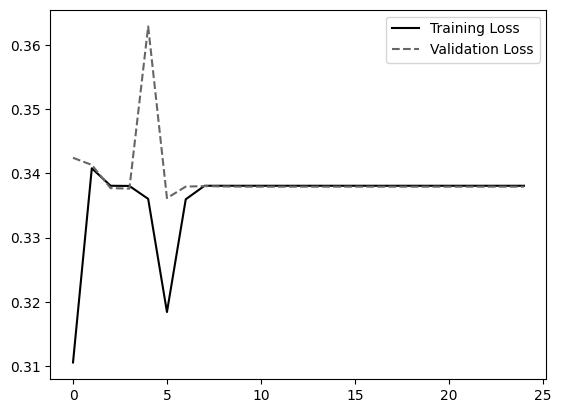

In [53]:
plt.plot(H.history["loss"], label="Training Loss")
plt.plot(H.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [54]:
x_train_pred = autoencoder.predict(teX[:7])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


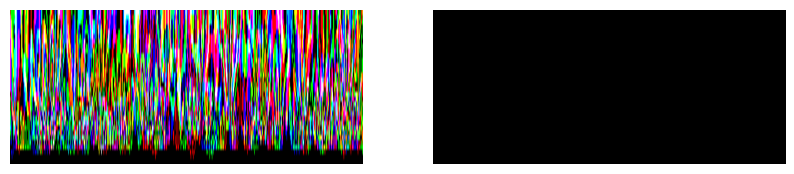

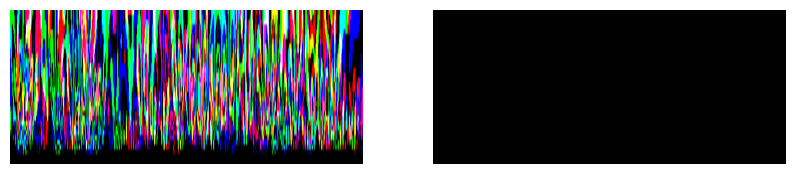

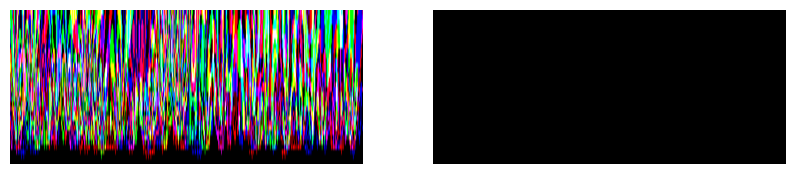

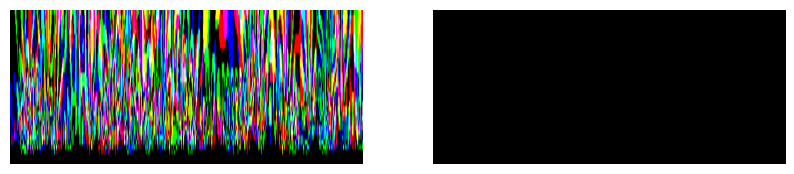

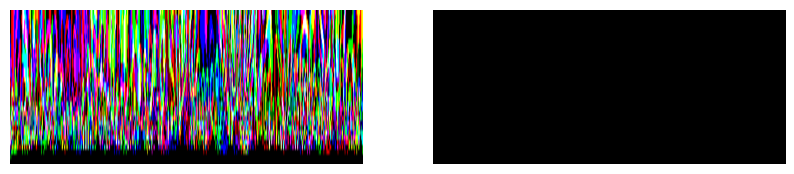

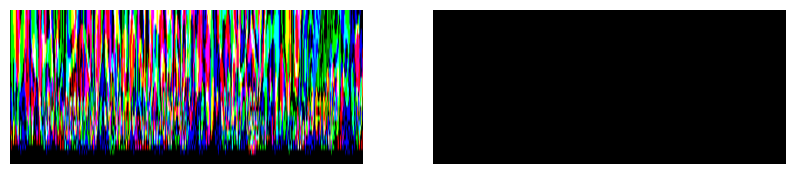

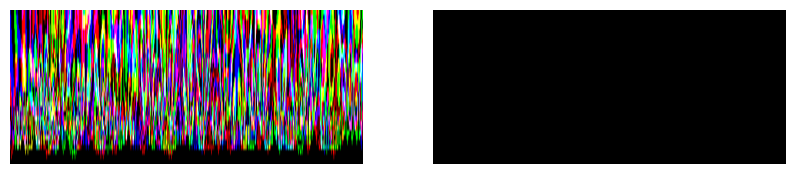

In [55]:

for i in range(7):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,2), dpi=100 )
    ax1.imshow(teX[i], origin='lower',aspect='auto')
    ax1.axis("off")
    ax2.imshow(x_train_pred[i], origin='lower',aspect='auto')
    plt.axis("off")
    plt.show()

In [56]:
del trX, teX

In [57]:
del x_train_pred
gc.collect

<function gc.collect(generation=2)>

In [58]:
toc = ti()
LR_Current = LR_Starting

In [59]:
j = LastSuccesfull + 1
autoencoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'_big_ae.keras')
encoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'_big_en.keras')
decoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'_big_de.keras')
print('saved 3DFP_'+DateString+'_'+str(j).zfill(3)+'autoencoder')

saved 3DFP_Good_007autoencoder


Loops Needed: 32
RAM after AllData: 11.9
RAM after Keeps: 24.0
RAM after Prints: 30.0
Exiting over memory usage
Epoch 1/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 59s 168ms/step - loss: 0.3284 - val_loss: 0.3284 - learning_rate: 0.0750
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - loss: 0.3285 - val_loss: 0.3284 - learning_rate: 0.0562
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - loss: 0.3284 - val_loss: 0.3284 - learning_rate: 0.0422
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - loss: 0.3284 - val_loss: 0.3285 - learning_rate: 0.0316
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - loss: 0.3284 - val_loss: 0.3284 - learning_rate: 0.0237
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - loss: 0.3282 - val_loss: 0.3284 - learning_rate: 0.0178
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - loss: 0.3286 - val_loss: 0.3284 - learning_rate: 0.0445
Epoch 8/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - loss: 0.3285 - val_loss: 0.3284 - learni

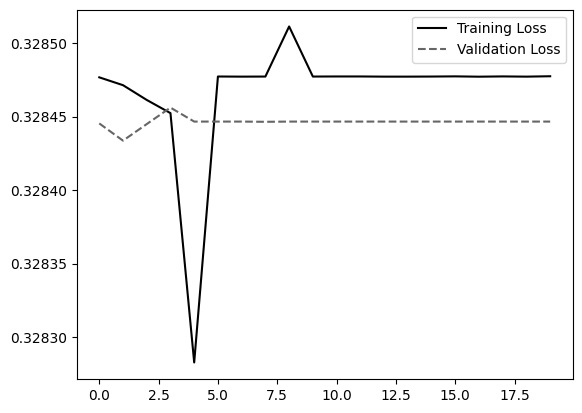

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


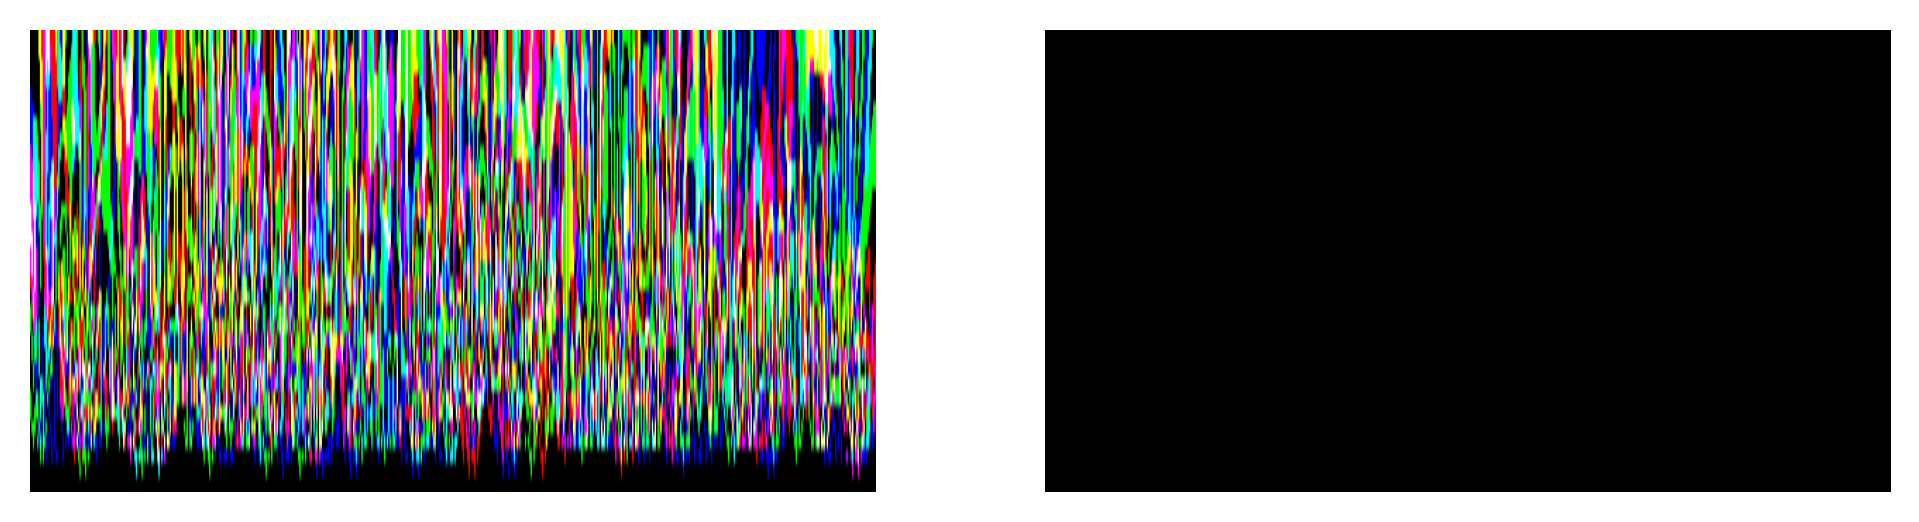

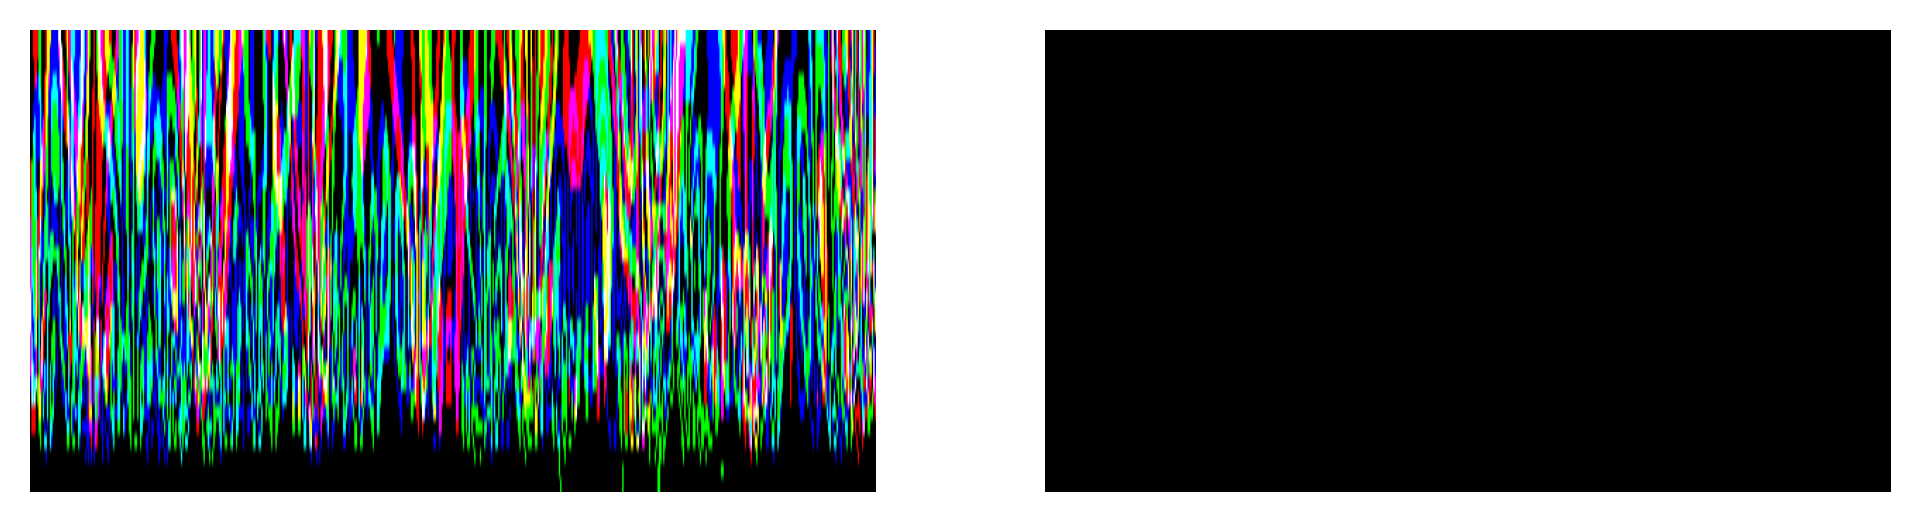

8 of 32 in 20.82 minutes. Using 36.6 of RAM
RAM after AllData: 36.5
RAM after Keeps: 53.1
RAM after Prints: 67.4
Exiting over memory usage


2024-12-02 14:46:22.655813: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20044569600 exceeds 10% of free system memory.
2024-12-02 14:47:12.886786: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18040089600 exceeds 10% of free system memory.
2024-12-02 14:47:18.789759: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18040089600 exceeds 10% of free system memory.


Epoch 1/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 98s 159ms/step - loss: 0.3358 - val_loss: 0.3363 - learning_rate: 0.0750
Epoch 2/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 80s 130ms/step - loss: 0.3360 - val_loss: 0.3363 - learning_rate: 0.0562
Epoch 3/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 80s 131ms/step - loss: 0.3358 - val_loss: 0.3363 - learning_rate: 0.0422
Epoch 4/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 80s 131ms/step - loss: 0.3360 - val_loss: 0.3363 - learning_rate: 0.0316
Epoch 5/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 80s 131ms/step - loss: 0.3360 - val_loss: 0.3363 - learning_rate: 0.0237
Epoch 6/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 80s 130ms/step - loss: 0.3359 - val_loss: 0.3363 - learning_rate: 0.0178
Epoch 7/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 80s 130ms/step - loss: 0.3361 - val_loss: 0.3363 - learning_rate: 0.0445
Epoch 8/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 79s 130ms/step - loss: 0.3358 - val_loss: 0.3363 - learning_rate: 0.0334
Epoch 9/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 79s 129ms/step - loss: 0.3359 - val_loss: 0.3363 - learn

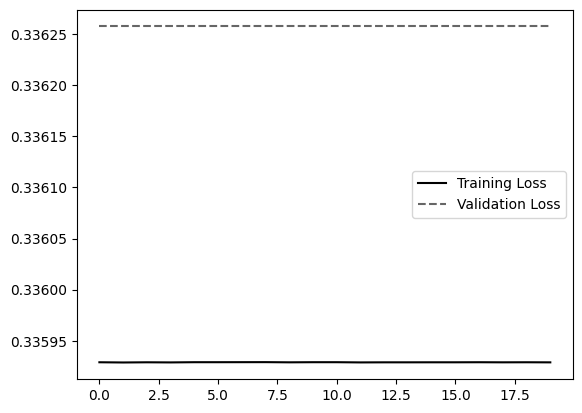

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


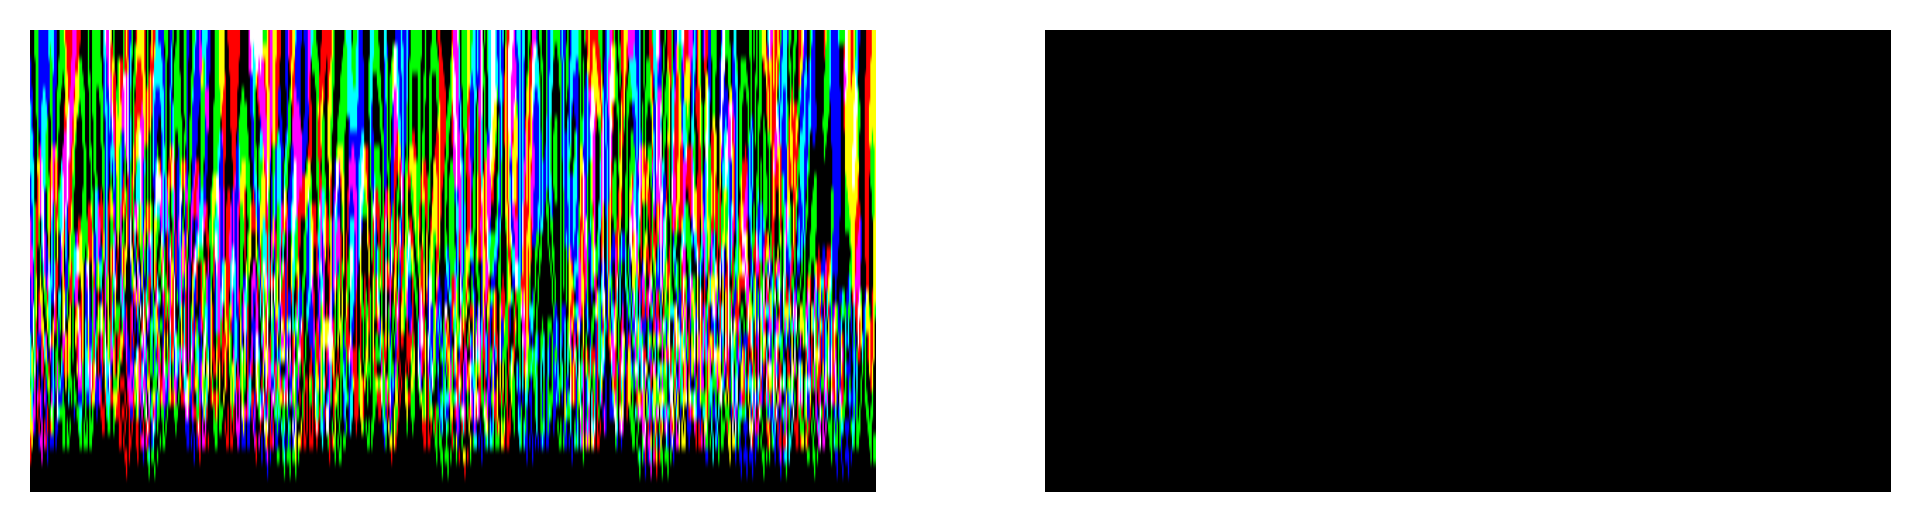

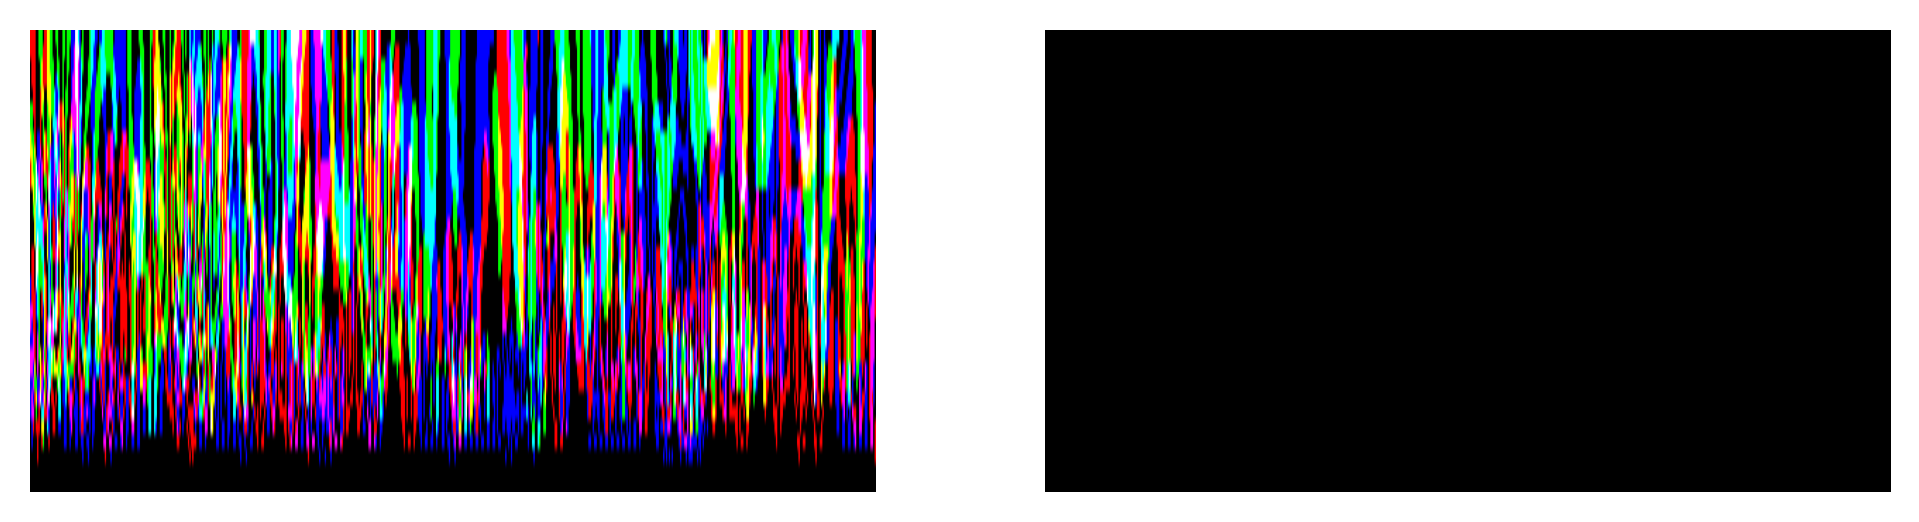

9 of 32 in 63.64 minutes. Using 68.3 of RAM


In [ ]:
if RunTwice:
    LoopsToGetAll = int(len(files)/FilesPerRun)-LastSuccesfull-1
    print(f'Loops Needed: {LoopsToGetAll}')
    for j in range(LoopsToGetAll):
        j+=2+LastSuccesfull
        Mats=[]
        AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runWrapper)(files[(j*FilesPerRun+i)], False, False, 0, ti()) for i in range(FilesPerRun))
        for fileResponse in AllDatas:
            for Mat in fileResponse:
                Mats.append(Mat)
        
        if MemoryProtection:
            del AllDatas
            print('RAM after AllData:', psutil.virtual_memory()[2])        
        lengths = []
        rejects = []
        Keeps = []
        
        for Mat in Mats:
            spm = np.shape(Mat)
            if len(spm) > 1:
                lenM = spm[1]
            else:
                lenM = 1
            if (lenM > 1250):
                lengths.append(lenM)
                Keeps.append(Mat)
            else:
                rejects.append(lenM)
        
        if MemoryProtection:
            del Mats
        
        Prints = []
        
        
        AllPrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Keeps)
        
        if MemoryProtection:
            del Keeps
            print('RAM after Keeps:', psutil.virtual_memory()[2])
        for group in AllPrints:
            for fprint in group:
                Prints.append(fprint[:, ::2, :])
        
        if MemoryProtection:
            del AllPrints
        
        
        random.shuffle(Prints)
        
        for i, image in enumerate(Prints):
            if not isinstance(image, np.ndarray):
                Prints[i] = np.array(image, dtype=np.float32)
            elif image.dtype != np.float32:
                Prints[i] = image.astype(np.float32)
        
        # Stack the images into a single NumPy array
        prints_array = np.stack(Prints, axis=0)
        
        if MemoryProtection:
            del Prints
            print('RAM after Prints:', psutil.virtual_memory()[2])
            if psutil.virtual_memory()[2] > 0.6:
                print('Exiting over memory usage')
                exit()
        
        # Convert the NumPy array to a TensorFlow tensor
        trX = tf.convert_to_tensor(prints_array)
        
        if MemoryProtection:
            del prints_array
        
        ImageShape = np.shape(trX)
        
        #trX = tensor_prints[:TestLength]  #tf.convert_to_tensor(trainX, dtype=tf.float32)
        
        #teX = tensor_prints[TestLength:]  #tf.convert_to_tensor(testX, dtype=tf.float32)
        
        #if MemoryProtection:
        #    del tensor_prints
        
        #checkpoint_callback = CustomModelCheckpoint(
        #    filepath='/scratch/models/3DFP_'+DateString+'_'+str(j)+'_{epoch:02d}.keras',
        #    save_freq=3  
        #)
        autoencoder.optimizer.learning_rate = LR_Starting
        LR_Current = LR_Starting
        
        H = autoencoder.fit(
        	trX, trX,
        	validation_split=0.1,
        	epochs=20,
            #callbacks=[checkpoint_callback, es_callback],     
            callbacks=[lr_scheduler],
        	batch_size=BS)
        
        plt.plot(H.history["loss"], label="Training Loss")
        plt.plot(H.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.show()

        #random.shuffle(trX)
        autoencoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'_big_ae.keras')
        encoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'_big_en.keras')
        decoder.save('/scratch/models/3DFP_'+DateString+'_'+str(j).zfill(3)+'_big_de.keras')

        
        x_train_pred = autoencoder.predict(trX[:2])
        
        for i in range(2):
            fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,2), dpi=300 )
            ax1.imshow(trX[i], origin='lower',aspect='auto')
            ax1.axis("off")
            ax2.imshow(x_train_pred[i], origin='lower',aspect='auto')
            ax2.axis("off")
            plt.show()

        del trX, x_train_pred, fig, ax1,ax2
        gc.collect()

        if j%LR_PeriodGrow == 0:
            LR_Current *= LR_Expand
        else:
            LR_Current *= LR_Decay
            
        autoencoder.optimizer.learning_rate = LR_Current
    
        print(f'{j} of {LoopsToGetAll} in {int((ti()-toc)/.6)/100} minutes. Using { psutil.virtual_memory()[2]} of RAM')